# Kaggle Use case

## Assignment Objective

The objective of this assignment is to build any model on the Instacart dataset which contains 3 million grocery orders from more than 200K Instacart users. For each of the users, there are 4 to 100 orders with the sequence of products purchased on each order. 

## Possible Objectives

Some of the possible objectives, but not limited to, that come to mind are-

* Predict items which will be reordered
* Recommend items to the user based on item-based and user-based associations
* Customer segmentation based on buying patterns
* Predicting next order date or days until next purchase

## Chosen Objective

**Predict next order date(days)** - The chosen objective is to predict number of days until the user places their next order. This could help the retailer in the following ways:-

* To avoid customer churn rate, i.e. if a customer does not order within a certain period of time as shown in the figure below, it would make sense to send across promotions or surveys before they are lost. Surveys would help us understand their preferences. 
* To upsell or cross-sell as and when the next purchase date approaches
* Provide subscriptions on product purchases. For example, a mouthwash is ordered every month
* To maintain sufficient inventory by using the next order date along with the re-order model (objective on kaggle to determine if a product will be re-ordered). This will also avoid customer dissatisfaction

Keeping the above in mind, a nascent model is built below on orders alone. A more mature model can be built considering the next date of purchase based on products. This will potentially learn more patterns being more granular.

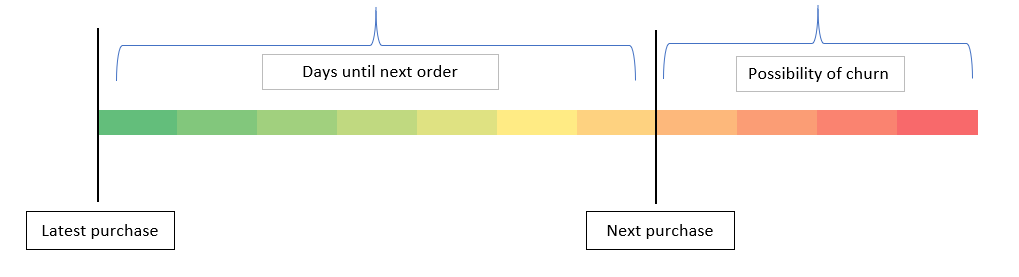

## Steps to modelling the chosen objective

The assignment will follow the below steps:

* Data understanding
* Data exploration
* Pre-processing
* Modelling
* Evaluation
* Next steps
    

## Data understanding

In this step, let's import the necessary libraries and look at the contents of each table

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

color = sns.color_palette()
pd.set_option('display.max_columns', None)

In [2]:
#Read individual files
order_products_train_df = pd.read_csv('Data/order_products__train.csv')
order_products_prior_df = pd.read_csv('Data/order_products__prior.csv')
orders_df = pd.read_csv('Data/orders.csv')
products_df = pd.read_csv('Data/products.csv')
aisles_df = pd.read_csv('Data/aisles.csv')
departments_df = pd.read_csv('Data/departments.csv')

In [3]:
#Printing the dimensions of each file
print("No of records in order_products_train_df: "+str(order_products_train_df.shape))
print("No of records in order_products_prior_df: "+str(order_products_prior_df.shape))
print("No of records in orders_df: "+str(orders_df.shape))
print("No of records in products_df: "+str(products_df.shape))
print("No of records in aisles_df: "+str(aisles_df.shape))
print("No of records in departments_df: "+str(departments_df.shape))

No of records in order_products_train_df: (1384617, 4)
No of records in order_products_prior_df: (32434489, 4)
No of records in orders_df: (3421083, 7)
No of records in products_df: (49688, 4)
No of records in aisles_df: (134, 2)
No of records in departments_df: (21, 2)


In [4]:
#Print sample records of each dataframe to know how the data looks like
print(order_products_train_df.head(2))

   order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1


The table order_products_train_df contains a unique order id, products bought in the order, the sequence of adding products to the order and if the product was reordered in the past by a user

In [5]:
print(order_products_prior_df.head(2))

   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1


The table order_products_prior_df has similar information as order_products_train_df

In [6]:
print(orders_df.head(2))

   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   

   days_since_prior_order  
0                     NaN  
1                    15.0  


The table orders_df has all information with respect to who placed the order, it's unique order id, the sequence of the orders showing order history, day of order (between 0 to 6 with no way of identifying if 0 starts from a particular day) and hour of order. 

A column **days_since_prior_order** shows the days after which the current order is placed. We will later use this as a target by shifting it up by one.

A column called **eval_set** has three unique levels, i.e. prior, train and test. They can be represented with the below diagram

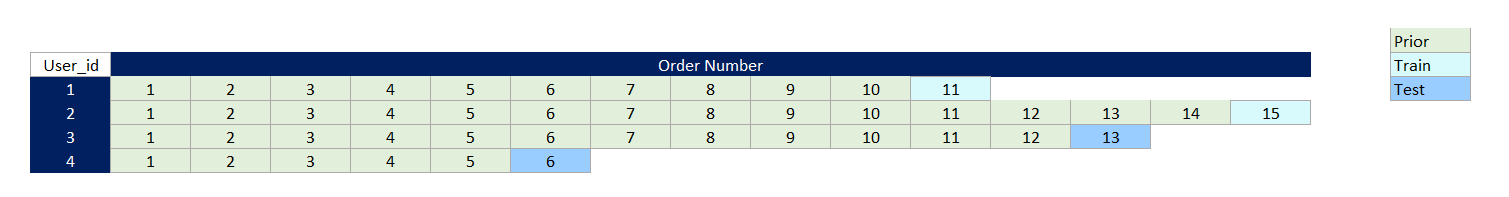

In [7]:
print(products_df.head(2))

   product_id                product_name  aisle_id  department_id
0           1  Chocolate Sandwich Cookies        61             19
1           2            All-Seasons Salt       104             13


In [8]:
print(aisles_df.head(2))

   aisle_id                  aisle
0         1  prepared soups salads
1         2      specialty cheeses


In [9]:
print(departments_df.head(2))

   department_id department
0              1     frozen
1              2      other


The table products_df shows the name of the product and the department & aisle it belongs to. The name of the department and the aisle can be found using the above two tables.

## Data Exploration

Exploring the data with some plots to better understand the distribution of columns

C:\Users\irfaa\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


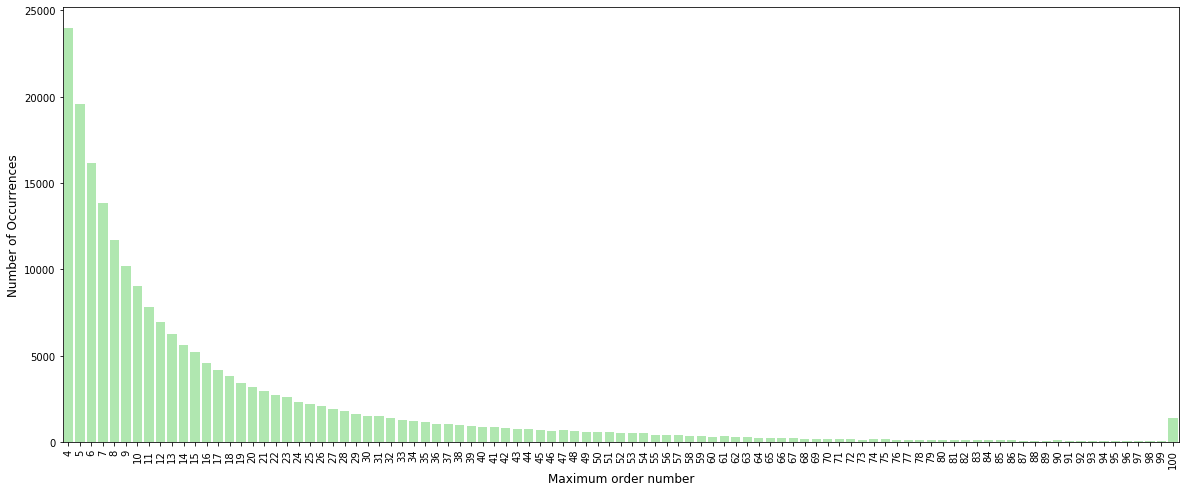

In [10]:
cnt_users = orders_df.groupby('user_id')['order_number'].aggregate(np.max).reset_index()
cnt_users = cnt_users.order_number.value_counts()

plt.figure(figsize=(20,8))
sns.barplot(cnt_users.index, cnt_users.values, alpha=0.8, color='lightgreen')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

This shows users have a minimum history of 4 orders and maximum of 100 orders

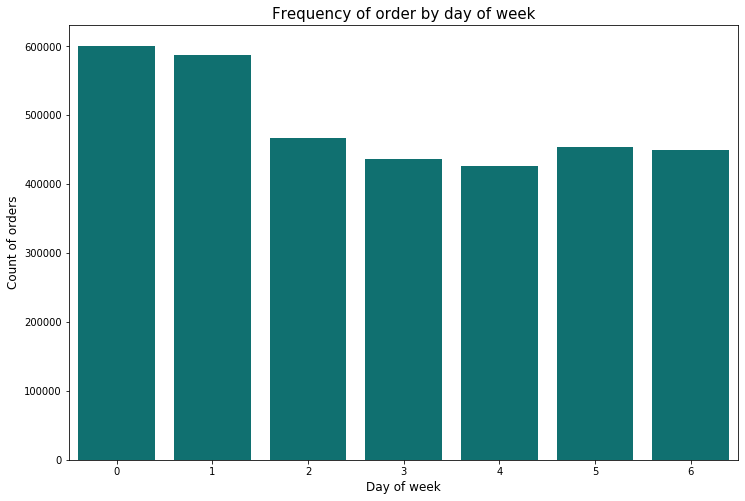

In [11]:
#Day of week
plt.figure(figsize=(12,8))
sns.countplot(x='order_dow', data=orders_df, color='teal')
plt.ylabel('Count of orders', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title('Frequency of order by day of week', fontsize=15)
plt.show()


More orders have been placed on DOW 0 and 1. One can assume these would have been placed over the weekend.

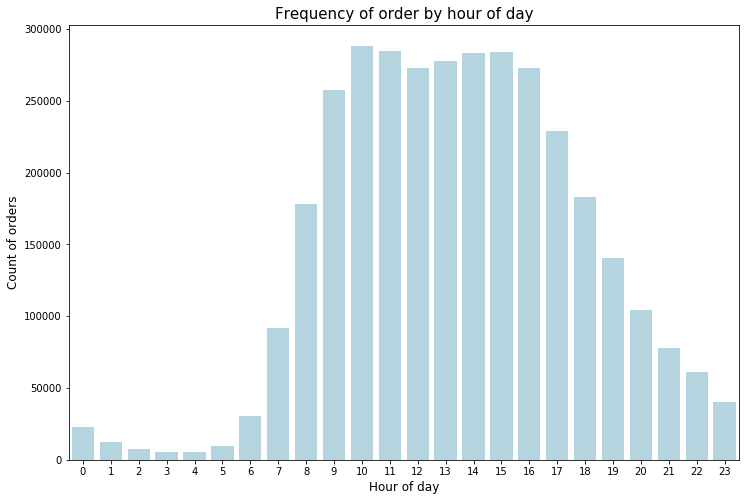

In [12]:
#Time of day
plt.figure(figsize=(12,8))
sns.countplot(x='order_hour_of_day', data=orders_df, color='lightblue')
plt.ylabel('Count of orders', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title('Frequency of order by hour of day', fontsize=15)
plt.show()

Majority of the orders are placed 9 AM onwards with few of them at midnight.

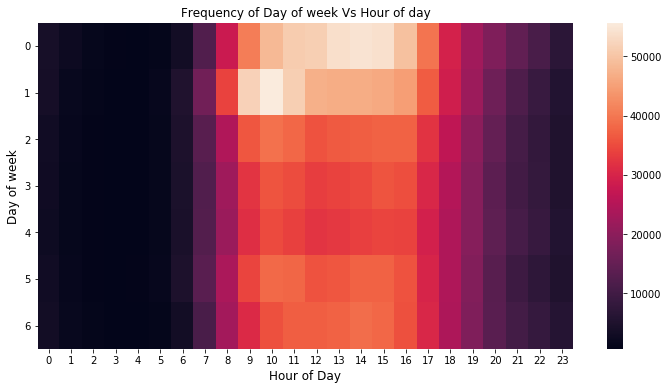

In [13]:
#Heat map to show Day of week and hour of day combination
grouped_df = orders_df.groupby(['order_dow', 'order_hour_of_day'])['order_number'].aggregate('count').reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title('Frequency of Day of week Vs Hour of day')
plt.ylabel('Day of week', fontsize=12)
plt.yticks(rotation='horizontal')
plt.xlabel('Hour of Day', fontsize=12)
plt.show()

The heatmap shows orders being placed majorly in the weekend and during the day.

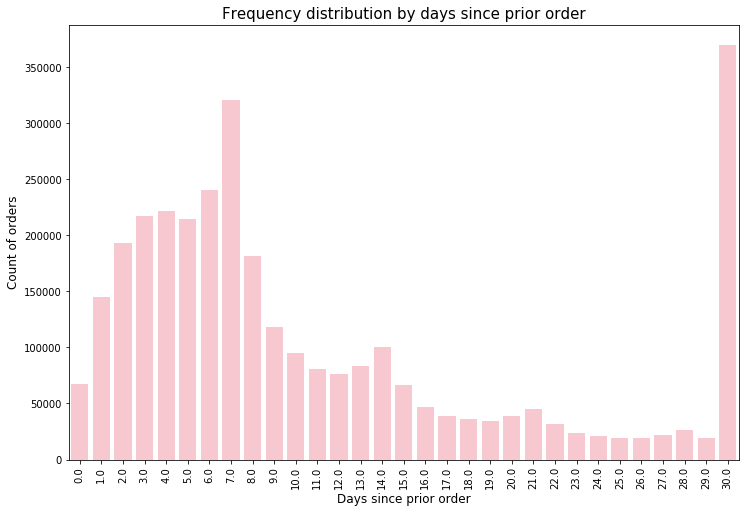

In [14]:
#Days since prior orders
plt.figure(figsize=(12,8))
sns.countplot(x='days_since_prior_order', data=orders_df, color='pink')
plt.ylabel('Count of orders', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency distribution by days since prior order', fontsize=15)
plt.show()

This shows a peak in the number of orders being placed every seven days which can be seen with small peaks in multiples of 7. The days are capped at 30. Hence, the largest peak there.

C:\Users\irfaa\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


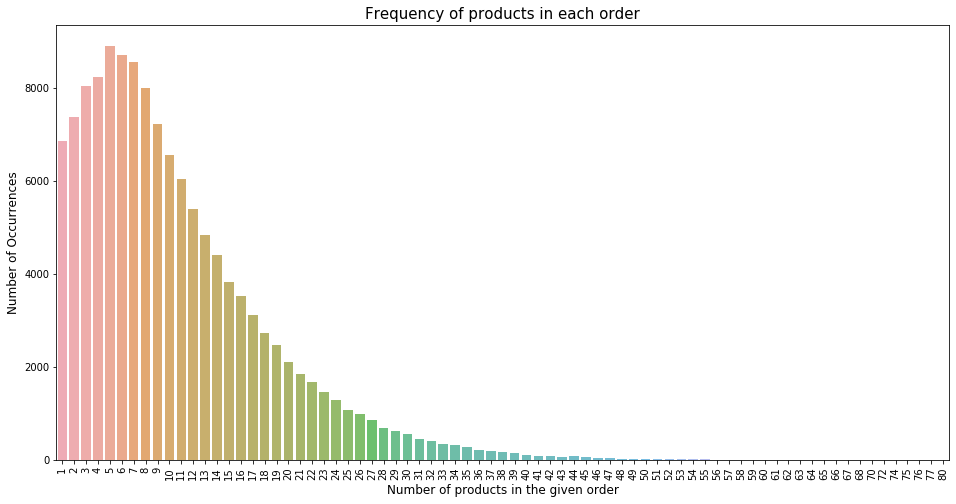

In [15]:
#No. of products bought in each order
grouped_df = order_products_train_df.groupby('order_id')['add_to_cart_order'].aggregate('max').reset_index()
cnt_users = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(16,8))
sns.barplot(cnt_users.index, cnt_users.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency of products in each order', fontsize=15)
plt.show()


Mode of the number of products being bought in each order is seen at 5 (This shows 5 different products being bought and does not represent quantity)

In [16]:
#Merging products and orders
order_products_all = order_products_prior_df.copy()
order_products_all = pd.merge(order_products_all, products_df, on='product_id', how='left')
order_products_all = pd.merge(order_products_all, aisles_df, on='aisle_id', how='left')
order_products_all = pd.merge(order_products_all, departments_df, on='department_id', how='left')
order_products_all.head()

#Most frequent products
cnt_users = order_products_all['product_name'].value_counts().reset_index().head(20)
cnt_users.columns = ['product_name', 'frequency_count']
cnt_users

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


Bananas or fresh fruits in general occupy the most frequently bought products

C:\Users\irfaa\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


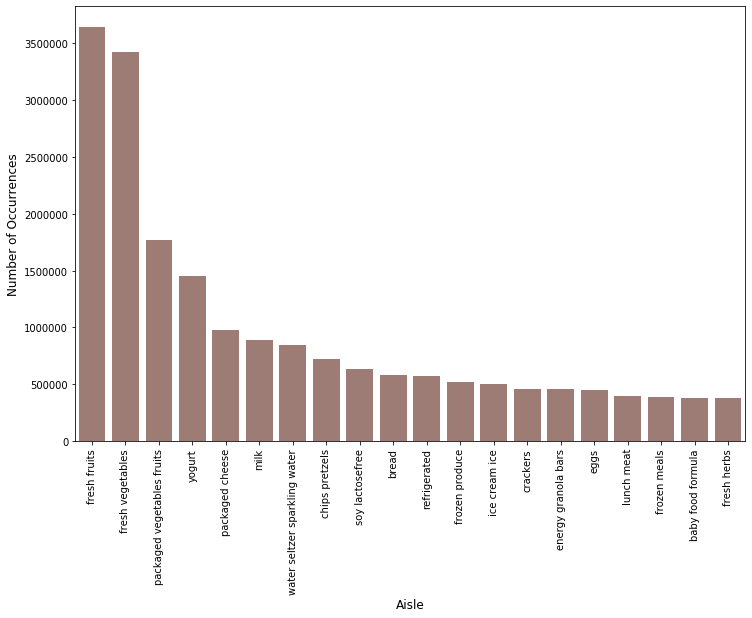

In [17]:
#Most frequent aisles
cnt_users = order_products_all['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(cnt_users.index, cnt_users.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Fresh fruits and vegetables are most frequently visited aisles that are also seen in terms of products

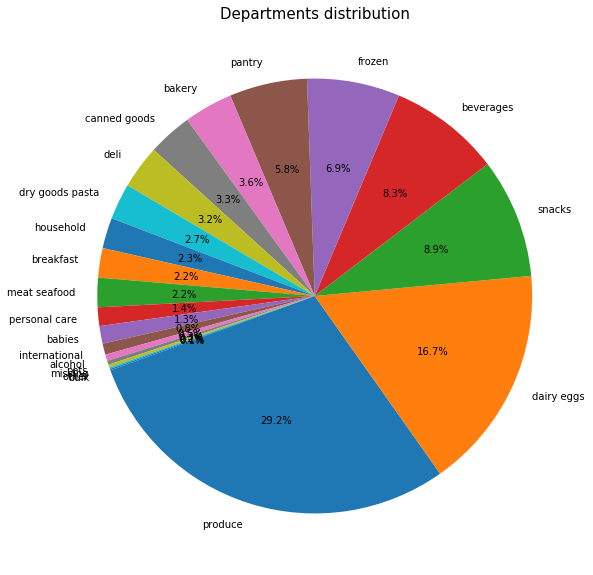

In [18]:
#Most frequent departments
plt.figure(figsize=(10,10))
temp_series = order_products_all['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title('Departments distribution', fontsize=15)
plt.show()

The biggest chunk ~30% is bought in produce followed by dairy and eggs. This makes sense as these have a short shelf life

C:\Users\irfaa\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


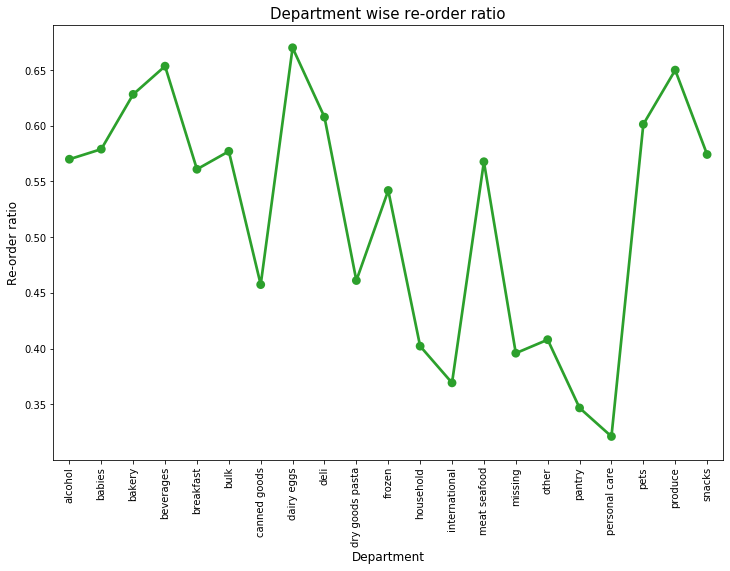

In [19]:
#Department reorder ratio
grouped_df = order_products_all.groupby(["department"])["reordered"].aggregate("mean").reset_index()
plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Re-order ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise re-order ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

Re-order ratio is defined as the number of items which were bought previously divided by the total number of products. Dairy & eggs department has the highest re-order ratio as compared to personal care which has the lowest. This makes sense as personal care products last longer and would not be bought often


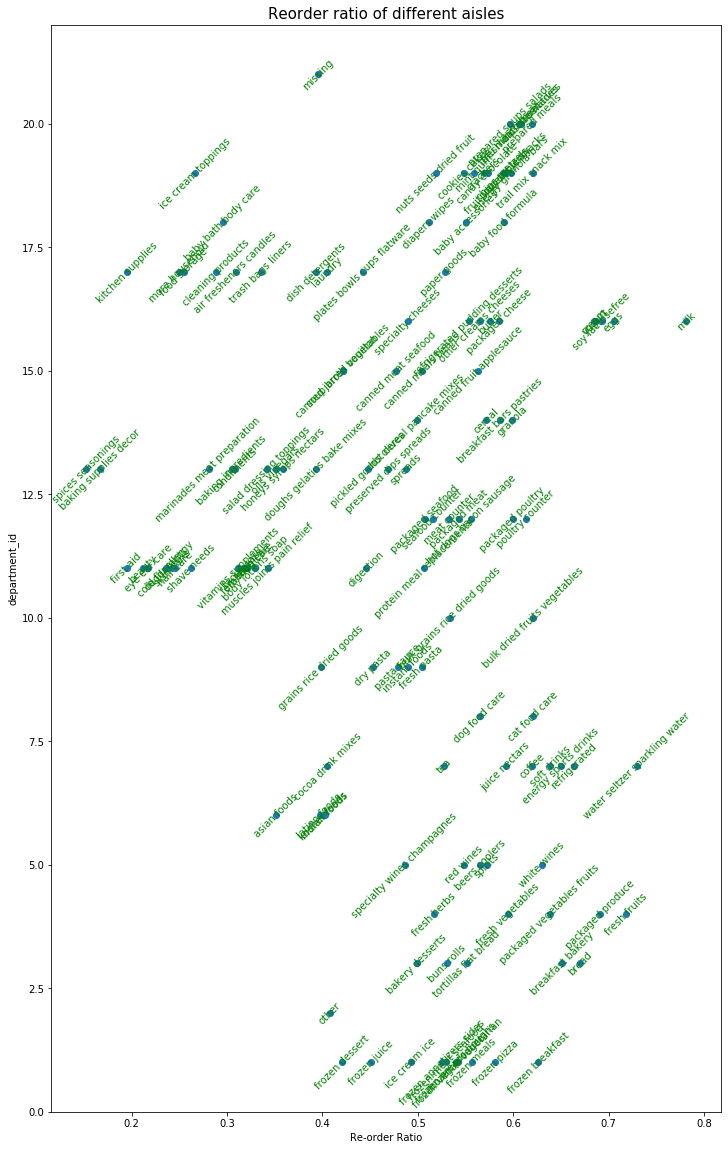

In [20]:
#Aisle reorder ratio
grouped_df = order_products_all.groupby(['department_id', 'aisle'])['reordered'].aggregate('mean').reset_index()
fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='green')
plt.xlabel('Re-order Ratio')
plt.ylabel('department_id')
plt.title("Reorder ratio of different aisles", fontsize=15)
plt.show()

This plot shows the department_id on the y-axis with the re-order ratio on the x-axis. Aisles are annotated based on their re-order ratio against their respective departments.

Baking supplies have a very low re-order ratio as compared to milk which is close to 80%

C:\Users\irfaa\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\irfaa\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


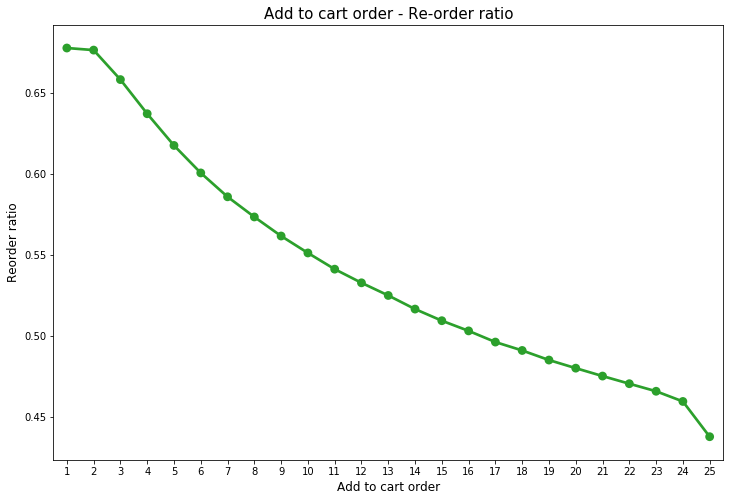

In [21]:
#Add to cart - Reorder ratio
order_products_all['add_to_cart_order_mod'] = order_products_all['add_to_cart_order'].copy()
order_products_all['add_to_cart_order_mod'].loc[order_products_all['add_to_cart_order_mod']>25] = 25
grouped_df = order_products_all.groupby(['add_to_cart_order_mod'])['reordered'].aggregate('mean').reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Re-order ratio", fontsize=15)
plt.show()


Items that are added first in the cart are the ones which are frequently ordered which is human tendency to add the ones which are consumed more often

C:\Users\irfaa\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


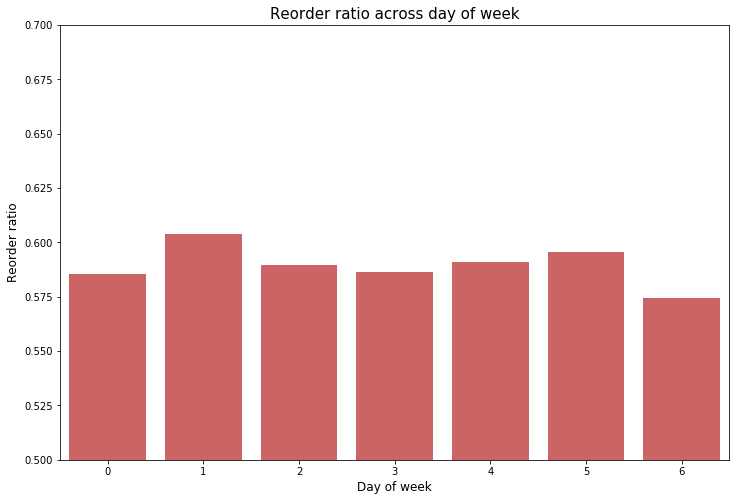

In [22]:
#DOW re-order ratio
order_products_all = pd.merge(order_products_all, orders_df, on='order_id', how='left')
grouped_df = order_products_all.groupby(['order_dow'])['reordered'].aggregate('mean').reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.ylim(0.5, 0.7)
plt.show()


There does not seem to be a pattern in the DOW and re-order ratio

C:\Users\irfaa\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


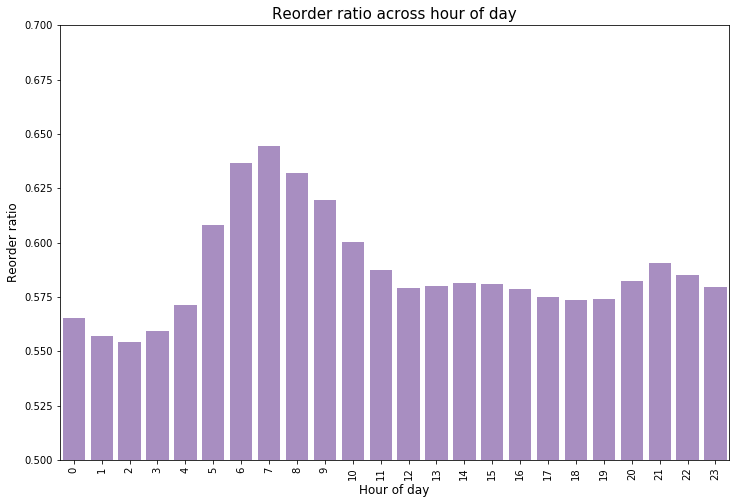

In [23]:
#Hour of day re-order ratio
grouped_df = order_products_all.groupby(['order_hour_of_day'])['reordered'].aggregate('mean').reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

Products ordered in the morning have a higher re-order ratio. This was seen in the blog shared from Instacart which showed fresh/healthy food being ordered in the morning and ice-cream being ordered later in the evening. The same can be seen in the heatmap below.

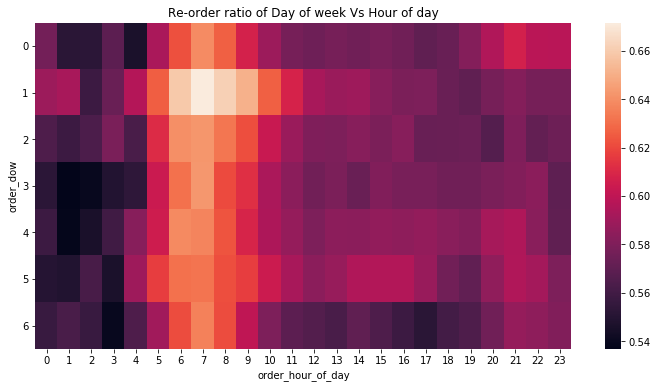

In [24]:
#DOW and hour of day combination
grouped_df = order_products_all.groupby(['order_dow', 'order_hour_of_day'])['reordered'].aggregate('mean').reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title('Re-order ratio of Day of week Vs Hour of day')
plt.yticks(rotation='horizontal')
plt.show()

## Methodology

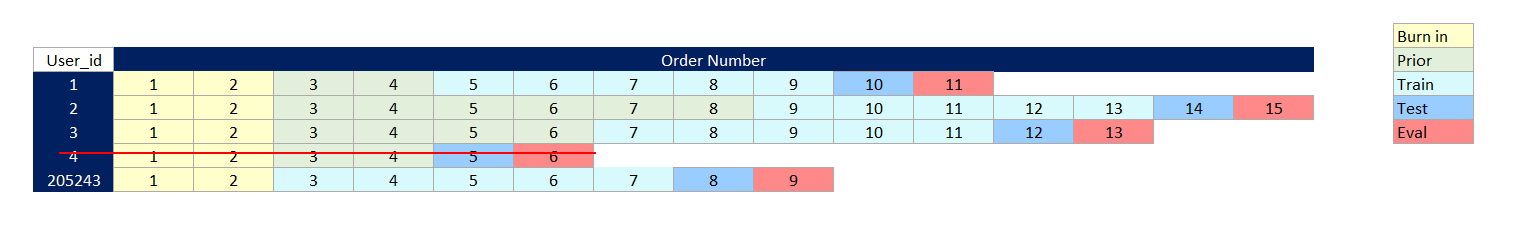

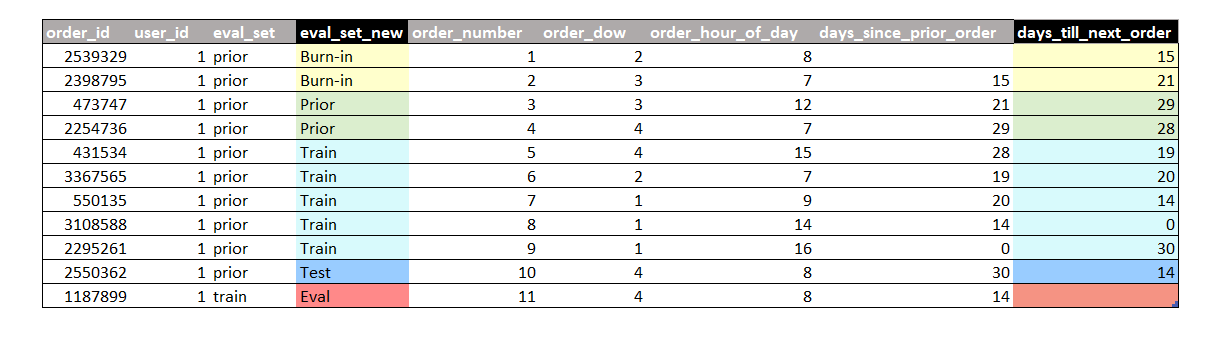

To start with, we will consider atleast 5000 users who have placed a minimum of 9 orders. The table has 5 categories-

* **Burn-in** - since these are the very first few orders, it does not provide a lot of information. However, these will still be                 used to derive information for future orders
* **Prior**   - orders which will be used to derive information for future orders. This will be applicable for the users who have placed more than 9 orders
* **Train**   - a window of 5 records which will be trained by the model
* **Test**    - to test how our model performs i.e the number of days until the next order
* **Eval**    - the latest order of the customer which will be passed to the model to predict when the future order will take place

In the first table, user_id 4 does not meet the criteria and will not be part of the train nor test as it does not have sufficient information to train and test. User_id 205243 just meets the criteria.

The second table shows the orders placed by user_id 1. A new column in created called **eval_set_new** which is based on these 5 categories. A new column called **days_till_next_order** is also created that will be the target the model will be trained on. The test set will determine how off is the model from the target. We will consider MAE (Mean absolute error) in days to evaluate this.

## Pre-Processing

In [25]:
#Filter the data to take 5000 random user_ids to test out our methodology
user_ids = orders_df.loc[orders_df.order_number==9,'user_id'].tolist()

random.seed(30)
user_ids=random.sample(user_ids,5000)

orders_df = orders_df[orders_df.user_id.isin(user_ids)]

#Filter data based on selected ids
order_products_train_df = order_products_train_df[order_products_train_df.order_id.isin(orders_df.order_id)]
order_products_prior_df = order_products_prior_df[order_products_prior_df.order_id.isin(orders_df.order_id)]

#Binding both prior and train sets
order_products = pd.concat([order_products_prior_df,order_products_train_df])

#Add product, aisle and department info by the respective keys
order_products = pd.merge(order_products, products_df, on='product_id', how='left')
order_products = pd.merge(order_products, aisles_df, on='aisle_id', how='left')
order_products = pd.merge(order_products, departments_df, on='department_id', how='left')

#Function to sum no of products and re-orders by order_id
def f(x):
    d = {}
    d['no_of_prods'] = x['product_id'].count()
    d['no_of_reord_prods'] = x['reordered'].sum()
    return pd.Series(d, index=['no_of_prods', 'no_of_reord_prods'])

#Aggregation of counts and reordered
count_of_prods = order_products.copy()
count_of_prods = count_of_prods.groupby('order_id').apply(f).reset_index()

print(count_of_prods.head())

   order_id  no_of_prods  no_of_reord_prods
0         3            8                  8
1        60           18                 15
2        79            8                  7
3       113            7                  1
4       135           10                  9


In [26]:
#Aggregation by department
count_by_dep = pd.pivot_table(order_products,values='product_id',index=['order_id'],columns=['department'],
                              aggfunc=np.size,fill_value=0).reset_index(drop=False)

#Prefix column names
new_names = [(i,'dep_'+i) for i in count_by_dep.columns[1:].values]
count_by_dep.rename(columns = dict(new_names), inplace=True)

#Aggregation by aisle
count_by_aisle = pd.pivot_table(order_products,values='product_id',index=['order_id'],columns=['aisle'],
                              aggfunc=np.size,fill_value=0).reset_index(drop=False)

#Prefix column names
new_names = [(i,'aisle_'+i) for i in count_by_aisle.columns[1:].values]
count_by_aisle.rename(columns = dict(new_names), inplace=True)

#Merge aisle with orders_df as this is more granular than departments
orders_df = pd.merge(orders_df, count_of_prods, on='order_id', how='left')
#orders_df = pd.merge(orders_df, count_by_dep, on='order_id', how='left')
orders_df = pd.merge(orders_df, count_by_aisle, on='order_id', how='left')

print(orders_df.head())

   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  no_of_prods  no_of_reord_prods  \
0                     NaN          5.0                0.0   
1                    15.0          6.0                3.0   
2                    21.0          5.0                3.0   
3                    29.0          5.0                5.0   
4                    28.0          8.0                5.0   

   aisle_air fresheners candles  aisle_asian foods  aisle_baby accessories  \
0                           0.0                0.0                     0.0   
1             

In [27]:
#Sort the data by user_id and order_number because the next step will involve taking a expanding mean
orders_df = orders_df.sort_values(['user_id','order_number'])

#Copy the dataframe and proceed with aggregations
temp_df = orders_df.copy()
cols = [col for col in temp_df if col.startswith('aisle_')]
cols.extend(['user_id','no_of_prods', 'no_of_reord_prods'])
temp_df = temp_df[cols]

#Choose only those columns that need to be aggregated
cols = [col for col in temp_df if col.startswith('aisle_')]
cols.extend(['no_of_prods', 'no_of_reord_prods'])

#Taking a mean from the start of the order and expand them as and when more orders are placed
temp_df_mean = (temp_df.groupby(['user_id'])[cols].apply(lambda x: x.shift(0).expanding().mean(skipna=True)))
temp_df_std = (temp_df.groupby(['user_id'])[cols].apply(lambda x: x.shift(0).expanding().std(skipna=True)))

#Mean
temp_df_mean_prods = temp_df_mean[['no_of_prods','no_of_reord_prods']]
temp_df_mean_prods.columns = ['mean_no_of_prods','mean_no_of_reord_prods']
temp_df_mean_prods=temp_df_mean_prods.reset_index(drop=True)

#Standard deviation
temp_df_std_prods = temp_df_std[['no_of_prods','no_of_reord_prods']]
temp_df_std_prods.columns = ['std_no_of_prods','std_no_of_reord_prods']
temp_df_std_prods=temp_df_std_prods.reset_index(drop=True)

#Choosing the most frequent aisle the user orders from 
cols = [col for col in temp_df_mean if col.startswith('aisle_')]
arr = np.argsort(-temp_df_mean[cols].values, axis=1)
temp_freq_aisle_mean = pd.DataFrame(temp_df_mean[cols].columns[arr], index=temp_df_mean[cols].index)
temp_freq_aisle_mean = temp_freq_aisle_mean[[0,1,2]]
temp_freq_aisle_mean.columns = ['mean_most_freq_aisle_1','mean_most_freq_aisle_2','mean_most_freq_aisle_3']
temp_freq_aisle_mean=temp_freq_aisle_mean.reset_index(drop=True)

#Concatenate all of them by column
temp_df = pd.concat([temp_df,temp_freq_aisle_mean,temp_df_mean_prods,temp_df_std_prods],axis=1)

#Choose columns
temp_df = temp_df[['user_id','mean_no_of_prods','mean_no_of_reord_prods','std_no_of_prods','std_no_of_reord_prods',
       'mean_most_freq_aisle_1', 'mean_most_freq_aisle_2', 'mean_most_freq_aisle_3']]

print(temp_df)

C:\Users\irfaa\anaconda3\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


        user_id  mean_no_of_prods  mean_no_of_reord_prods  std_no_of_prods  \
0             1          5.000000                0.000000              NaN   
1             1          5.500000                1.500000         0.707107   
2             1          5.333333                2.000000         0.577350   
3             1          5.250000                2.750000         0.500000   
4             1          5.800000                3.200000         1.303840   
...         ...               ...                     ...              ...   
122662   206183         12.909091                8.181818         5.393599   
122663   206183         13.583333                8.916667         5.648143   
122664   206183         14.230769                9.461538         5.890018   
122665   206183         14.214286                9.714286         5.659282   
122666   206183         14.214286                9.714286         5.659282   

        std_no_of_reord_prods mean_most_freq_aisle_1  mean_most

In [28]:
#Drop user_id to not duplicate before binding as the records are in the same index
orders_df = orders_df.drop(['user_id'],axis=1)

#Dropping old columns of aisles
cols = [col for col in orders_df if col.startswith('aisle_')]
orders_df = orders_df.drop(cols,axis=1)

#Bind with orders_df to get users that shop the most freq aisle along with mean and std dev of the number of products
orders_df = pd.concat([orders_df,temp_df],axis=1)
print(orders_df.head())

   order_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329    prior             1          2                  8   
1   2398795    prior             2          3                  7   
2    473747    prior             3          3                 12   
3   2254736    prior             4          4                  7   
4    431534    prior             5          4                 15   

   days_since_prior_order  no_of_prods  no_of_reord_prods  user_id  \
0                     NaN          5.0                0.0        1   
1                    15.0          6.0                3.0        1   
2                    21.0          5.0                3.0        1   
3                    29.0          5.0                5.0        1   
4                    28.0          8.0                5.0        1   

   mean_no_of_prods  mean_no_of_reord_prods  std_no_of_prods  \
0          5.000000                    0.00              NaN   
1          5.500000                    1.5

In [29]:
#Making another copy of orders_df to create more features based on the days_since_prior_order
temp_df = orders_df.copy()
temp_df = temp_df[['user_id','order_number','days_since_prior_order']]

#Deriving mean, std dev, min and max of "days_since_prior_order"
temp_df['mean_days_since_order'] = (temp_df.groupby(['user_id'])['days_since_prior_order'].apply(lambda x: x.shift(0).expanding().mean(skipna=True)))
temp_df['std_days_since_order'] = (temp_df.groupby(['user_id'])['days_since_prior_order'].apply(lambda x: x.shift(0).expanding().std(skipna=True)))
temp_df['max_days_since_order'] = (temp_df.groupby(['user_id'])['days_since_prior_order'].apply(lambda x: x.shift(0).expanding().max(skipna=True)))
temp_df['min_days_since_order'] = (temp_df.groupby(['user_id'])['days_since_prior_order'].apply(lambda x: x.shift(0).expanding().min(skipna=True)))

#Add lagged variables to each order. This will show how many days before did the user place an order and the days before that and so on
#Creating upto 5 lags
temp_df['days_since_prior1_order'] = temp_df['days_since_prior_order'].copy()
temp_df['days_since_prior2_order'] = (temp_df.groupby(['user_id'])['days_since_prior_order'].shift(1))
temp_df['days_since_prior3_order'] = (temp_df.groupby(['user_id'])['days_since_prior_order'].shift(2))
temp_df['days_since_prior4_order'] = (temp_df.groupby(['user_id'])['days_since_prior_order'].shift(3))
temp_df['days_since_prior5_order'] = (temp_df.groupby(['user_id'])['days_since_prior_order'].shift(4))

#Dropping this column because days_since_prior1_order is the same
temp_df = temp_df.drop(['days_since_prior_order'],axis=1)

print(temp_df.head())

#Merging with the base table
orders_df = pd.merge(orders_df,temp_df,how='left',on=['user_id','order_number'])

   user_id  order_number  mean_days_since_order  std_days_since_order  \
0        1             1                    NaN                   NaN   
1        1             2              15.000000                   NaN   
2        1             3              18.000000              4.242641   
3        1             4              21.666667              7.023769   
4        1             5              23.250000              6.551081   

   max_days_since_order  min_days_since_order  days_since_prior1_order  \
0                   NaN                   NaN                      NaN   
1                  15.0                  15.0                     15.0   
2                  21.0                  15.0                     21.0   
3                  29.0                  15.0                     29.0   
4                  29.0                  15.0                     28.0   

   days_since_prior2_order  days_since_prior3_order  days_since_prior4_order  \
0                      NaN          

In [30]:
#Shift value by one to create our target that will be the dependent variable
orders_df['days_till_next_order'] = (orders_df.groupby(['user_id'])['days_since_prior_order'].shift(-1))

#Reorder eval_set column to eval_set_new as shown in the methodology
orders_df['eval_set_new'] = np.where(orders_df['eval_set'].isin(['train','test']),'eval',
                                     np.where(orders_df['eval_set'].shift(-1).isin(['train','test']),'test',
                                              'prior'))
print(orders_df.head(11))

    order_id eval_set  order_number  order_dow  order_hour_of_day  \
0    2539329    prior             1          2                  8   
1    2398795    prior             2          3                  7   
2     473747    prior             3          3                 12   
3    2254736    prior             4          4                  7   
4     431534    prior             5          4                 15   
5    3367565    prior             6          2                  7   
6     550135    prior             7          1                  9   
7    3108588    prior             8          1                 14   
8    2295261    prior             9          1                 16   
9    2550362    prior            10          4                  8   
10   1187899    train            11          4                  8   

    days_since_prior_order  no_of_prods  no_of_reord_prods  user_id  \
0                      NaN          5.0                0.0        1   
1                     15.0   

In [31]:
#Filter latest 7 orders. These will include 1 of eval, 1 test and 5 train
orders_df = orders_df.groupby('user_id').tail(7).reset_index(drop=True)

In [32]:
#To have the right label
orders_df['eval_set_new'] = np.where(orders_df['eval_set_new']=='prior','train',orders_df['eval_set_new'])

#Ordering the columns
orders_df = orders_df[['user_id','order_id','order_number','order_dow','order_hour_of_day','mean_no_of_prods',
                       'mean_no_of_reord_prods','std_no_of_prods','std_no_of_reord_prods',
                       'mean_most_freq_aisle_1', 'mean_most_freq_aisle_2','mean_most_freq_aisle_3',
                       'mean_days_since_order','std_days_since_order', 
                       'max_days_since_order', 'min_days_since_order',
                       'days_since_prior1_order', 'days_since_prior2_order',
                       'days_since_prior3_order', 'days_since_prior4_order',
                       'days_since_prior5_order', 
                       'days_till_next_order', 
                       'eval_set_new']]

orders_df.head(6)

,user_id,order_id,order_number,order_dow,order_hour_of_day,mean_no_of_prods,mean_no_of_reord_prods,std_no_of_prods,std_no_of_reord_prods,mean_most_freq_aisle_1,mean_most_freq_aisle_2,mean_most_freq_aisle_3,mean_days_since_order,std_days_since_order,max_days_since_order,min_days_since_order,days_since_prior1_order,days_since_prior2_order,days_since_prior3_order,days_since_prior4_order,days_since_prior5_order,days_till_next_order,eval_set_new
0,1,431534,5,4,15,5.800000,3.200000,1.303840,2.049390,aisle_popcorn jerky,aisle_soft drinks,aisle_fresh fruits,23.250000,6.551081,29.0,15.0,28.0,29.0,21.0,15.0,NaN,19.0,train
1,1,3367565,6,2,7,5.500000,3.333333,1.378405,1.861899,aisle_popcorn jerky,aisle_soft drinks,aisle_fresh fruits,22.400000,5.983310,29.0,15.0,19.0,28.0,29.0,21.0,15.0,20.0,train
2,1,550135,7,1,9,5.428571,3.571429,1.272418,1.812654,aisle_popcorn jerky,aisle_soft drinks,aisle_nuts seeds dried fruit,22.000000,5.440588,29.0,15.0,20.0,19.0,28.0,29.0,21.0,14.0,train
3,1,3108588,8,1,14,5.500000,3.625000,1.195229,1.685018,aisle_popcorn jerky,aisle_soft drinks,aisle_nuts seeds dried fruit,20.857143,5.814596,29.0,14.0,14.0,20.0,19.0,28.0,29.0,0.0,train
4,1,2295261,9,1,16,5.555556,3.888889,1.130388,1.763834,aisle_popcorn jerky,aisle_soft drinks,aisle_nuts seeds dried fruit,18.250000,9.130013,29.0,0.0,0.0,14.0,20.0,19.0,28.0,30.0,train
5,1,2550362,10,4,8,5.900000,4.100000,1.523884,1.791957,aisle_soft drinks,aisle_popcorn jerky,aisle_nuts seeds dried fruit,19.555556,9.395625,30.0,0.0,30.0,0.0,14.0,20.0,19.0,14.0,test


In [33]:
#Checking nulls
orders_df.isnull().sum()

user_id                       0
order_id                      0
order_number                  0
order_dow                     0
order_hour_of_day             0
mean_no_of_prods              0
mean_no_of_reord_prods        0
std_no_of_prods               0
std_no_of_reord_prods         0
mean_most_freq_aisle_1        0
mean_most_freq_aisle_2        0
mean_most_freq_aisle_3        0
mean_days_since_order         0
std_days_since_order          0
max_days_since_order          0
min_days_since_order          0
days_since_prior1_order       0
days_since_prior2_order       0
days_since_prior3_order     422
days_since_prior4_order    1176
days_since_prior5_order    2253
days_till_next_order       5000
eval_set_new                  0
dtype: int64

In [34]:
#Choosing columns that need to be backfilled if NaN for days. This is because we are taking a longer history of orders
cols=['days_since_prior3_order', 'days_since_prior4_order','days_since_prior5_order']

grp = orders_df.groupby(['user_id'])
for g in cols:
    orders_df[g] = grp[g].bfill()

In [35]:
#Split the data into train and test
train_df = orders_df[orders_df.eval_set_new.isin(['train'])]
test_df = orders_df[orders_df.eval_set_new.isin(['test'])]

print("Length of train_df", str(len(train_df)))
print("Length of test_df", str(len(test_df)))

Length of train_df 25000
Length of test_df 5000


Since the most frequent aisle is categorical, we'll try to convert this to an ordered label using the mean of **days_since_prior_order** based on the aisles. The hypothesis is, people who buy products from these aisles often will do so based on the shelf life of the product. For example, people who buy fresh produce regularly cannot stock these for weeks and would prefer buying them fresh. Hence, the **days_since_prior** may be an indicator. These will not be totally accurate unless we go within each product and the quantity they purchase

In [36]:
cat_features = ['mean_most_freq_aisle_1', 'mean_most_freq_aisle_2', 'mean_most_freq_aisle_3']

#Running these separately so there is no data leakage
train_df_labels = pd.DataFrame()
for feature in cat_features:
    labels_ordered=train_df.groupby([feature])['days_since_prior1_order'].mean().sort_values().index
    labels_ordered={k:i for i,k in enumerate(labels_ordered,0)}
    train_df[feature]=train_df[feature].map(labels_ordered)
    labels_ordered=pd.DataFrame(labels_ordered.items())
    labels_ordered.columns=['level','value']
    labels_ordered['feature'] = feature    
    train_df_labels = train_df_labels.append(labels_ordered, ignore_index=True)  

for feature in cat_features:
    labels_ordered=train_df_labels.loc[train_df_labels['feature']==feature,'level']
    labels_ordered={k:i for i,k in enumerate(labels_ordered,0)}
    test_df[feature]=test_df[feature].map(labels_ordered)

C:\Users\irfaa\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\irfaa\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [37]:
#Print training dataset
print(train_df.head())

   user_id  order_id  order_number  order_dow  order_hour_of_day  \
0        1    431534             5          4                 15   
1        1   3367565             6          2                  7   
2        1    550135             7          1                  9   
3        1   3108588             8          1                 14   
4        1   2295261             9          1                 16   

   mean_no_of_prods  mean_no_of_reord_prods  std_no_of_prods  \
0          5.800000                3.200000         1.303840   
1          5.500000                3.333333         1.378405   
2          5.428571                3.571429         1.272418   
3          5.500000                3.625000         1.195229   
4          5.555556                3.888889         1.130388   

   std_no_of_reord_prods  mean_most_freq_aisle_1  mean_most_freq_aisle_2  \
0               2.049390                      94                      52   
1               1.861899                      94      

## Modelling

In this step we will try to run a XGBoost model. The reason I've used this model is because it utilizes all cores and parallelizes in the tree construction. This makes it ideal for running a large training set. 

It builds sequentials trees and trains by using the errors as a dependent variable and then moves towards the target. It creates binary trees within each iteration and the value of eta determines the rate at which it learns the patterns. 

We will train with RMSE as an evaluation metric for learning since we have capped the days at 30 and these do not represent anomalies. If we had a lot of outliers, we would consider using MAE as it deals with them better than RMSE.

In [38]:
#Load libraries and function

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
def calc_metrics(Actual,Prediction):
    
    MAE=mean_absolute_error(Actual['days_till_next_order'], Prediction)
    MSE=mean_squared_error(Actual['days_till_next_order'], Prediction)
    RMSE=np.sqrt(mean_squared_error(Actual['days_till_next_order'], Prediction))
    
    #Printing metrics
    print('MAE: '+str(MAE))
    print('MSE: '+str(MSE))
    print('RMSE: '+str(RMSE))
    


In [39]:
filtered_features_xgb = ['order_number','mean_no_of_prods','mean_no_of_reord_prods',
                         'std_no_of_prods','std_no_of_reord_prods',
                         'mean_most_freq_aisle_1', 'mean_most_freq_aisle_2', 'mean_most_freq_aisle_3',
                         'max_days_since_order',
                         'min_days_since_order',
                         'days_since_prior1_order','days_since_prior2_order',
                         'days_since_prior3_order','days_since_prior4_order', 
                         'days_since_prior5_order']

Features used for training:

* **order_number** - Orders placed by a user till date
* **mean_no_of_prods** - Mean of the number of products placed till date
* **mean_no_of_reord_prods** - Mean of the number of products re-ordered till date
* **std_no_of_prods** - standard deviation of the number of products placed till date
* **std_no_of_reord_prods** - standard deviation of the number of products re-ordered till date
* **mean_most_freq_aisle_1** - most frequent aisle ordered from
* **mean_most_freq_aisle_2** - second most frequent aisle ordered from
* **mean_most_freq_aisle_3** - third most frequent aisle ordered from
* **max_days_since_order** - max days since an order was placed
* **min_days_since_order** - min days since an order was placed
* **days_since_prior1_order** - days since last order was placed
* **days_since_prior2_order** - days since second last order was placed till last order
* **days_since_prior3_order** - days since third last order was placed till second last order
* **days_since_prior4_order** - days since fourth last order was placed till third last order
* **days_since_prior5_order** - days since fifth last order was placed till fourth last order

In [40]:
#Random search for best parameters

random_grid = {
        'n_estimators': [5000], #no of trees
        'max_depth':[2,3,6,9], #the depth of the tree. Large values make it more complex
        'min_child_weight': [1,5,10,20,25,50], #high values determine the model being more conservative. Lower values tend to overfit
        'eta':[0.01,0.05,0.1], #rate at which it moves towards the target. Lower values with more estimators reach an optimum value
        'subsample': [1,0.8,0.5],# percentage of records for training
        'colsample_bytree': [0.8,1]} #percentage of features for training

Xgb = XGBRegressor()

Xgb_random = RandomizedSearchCV(estimator = Xgb, param_distributions = random_grid, n_iter = 50, cv = 3,
                               verbose=2, random_state=0, n_jobs = -1,return_train_score=True,
                               scoring='neg_root_mean_squared_error')

eval_set = [(test_df[filtered_features_xgb], test_df['days_till_next_order'])]

#Fit the random search model
Xgb_random.fit(train_df[filtered_features_xgb], train_df['days_till_next_order'],
               eval_set=eval_set, verbose=True,early_stopping_rounds=10,eval_metric='rmse')

print(Xgb_random.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.2s


[0]	validation_0-rmse:17.03025
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:16.92477
[2]	validation_0-rmse:16.82104
[3]	validation_0-rmse:16.71791
[4]	validation_0-rmse:16.61598
[5]	validation_0-rmse:16.51725
[6]	validation_0-rmse:16.41753
[7]	validation_0-rmse:16.31991
[8]	validation_0-rmse:16.22377
[9]	validation_0-rmse:16.12763
[10]	validation_0-rmse:16.03403


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.6min finished


[11]	validation_0-rmse:15.94024
[12]	validation_0-rmse:15.84732
[13]	validation_0-rmse:15.75659
[14]	validation_0-rmse:15.66642
[15]	validation_0-rmse:15.57720
[16]	validation_0-rmse:15.48965
[17]	validation_0-rmse:15.40367
[18]	validation_0-rmse:15.31785
[19]	validation_0-rmse:15.23360
[20]	validation_0-rmse:15.15021
[21]	validation_0-rmse:15.06779
[22]	validation_0-rmse:14.98752
[23]	validation_0-rmse:14.90753
[24]	validation_0-rmse:14.82888
[25]	validation_0-rmse:14.75138
[26]	validation_0-rmse:14.67511
[27]	validation_0-rmse:14.59965
[28]	validation_0-rmse:14.52510
[29]	validation_0-rmse:14.45096
[30]	validation_0-rmse:14.37856
[31]	validation_0-rmse:14.30644
[32]	validation_0-rmse:14.23516
[33]	validation_0-rmse:14.16542
[34]	validation_0-rmse:14.09642
[35]	validation_0-rmse:14.02812
[36]	validation_0-rmse:13.96105
[37]	validation_0-rmse:13.89473
[38]	validation_0-rmse:13.82910
[39]	validation_0-rmse:13.76415
[40]	validation_0-rmse:13.69933
[41]	validation_0-rmse:13.63692
[42]	val

[266]	validation_0-rmse:9.29582
[267]	validation_0-rmse:9.29336
[268]	validation_0-rmse:9.29018
[269]	validation_0-rmse:9.28716
[270]	validation_0-rmse:9.28447
[271]	validation_0-rmse:9.28199
[272]	validation_0-rmse:9.27906
[273]	validation_0-rmse:9.27620
[274]	validation_0-rmse:9.27333
[275]	validation_0-rmse:9.27054
[276]	validation_0-rmse:9.26741
[277]	validation_0-rmse:9.26526
[278]	validation_0-rmse:9.26296
[279]	validation_0-rmse:9.26019
[280]	validation_0-rmse:9.25762
[281]	validation_0-rmse:9.25455
[282]	validation_0-rmse:9.25186
[283]	validation_0-rmse:9.24930
[284]	validation_0-rmse:9.24665
[285]	validation_0-rmse:9.24450
[286]	validation_0-rmse:9.24183
[287]	validation_0-rmse:9.23881
[288]	validation_0-rmse:9.23615
[289]	validation_0-rmse:9.23388
[290]	validation_0-rmse:9.23150
[291]	validation_0-rmse:9.22912
[292]	validation_0-rmse:9.22749
[293]	validation_0-rmse:9.22492
[294]	validation_0-rmse:9.22334
[295]	validation_0-rmse:9.22175
[296]	validation_0-rmse:9.21950
[297]	va

[523]	validation_0-rmse:9.04076
[524]	validation_0-rmse:9.04031
[525]	validation_0-rmse:9.04030
[526]	validation_0-rmse:9.04007
[527]	validation_0-rmse:9.03986
[528]	validation_0-rmse:9.03942
[529]	validation_0-rmse:9.03937
[530]	validation_0-rmse:9.03924
[531]	validation_0-rmse:9.03912
[532]	validation_0-rmse:9.03901
[533]	validation_0-rmse:9.03875
[534]	validation_0-rmse:9.03830
[535]	validation_0-rmse:9.03811
[536]	validation_0-rmse:9.03822
[537]	validation_0-rmse:9.03797
[538]	validation_0-rmse:9.03794
[539]	validation_0-rmse:9.03789
[540]	validation_0-rmse:9.03781
[541]	validation_0-rmse:9.03762
[542]	validation_0-rmse:9.03736
[543]	validation_0-rmse:9.03732
[544]	validation_0-rmse:9.03710
[545]	validation_0-rmse:9.03706
[546]	validation_0-rmse:9.03693
[547]	validation_0-rmse:9.03691
[548]	validation_0-rmse:9.03662
[549]	validation_0-rmse:9.03656
[550]	validation_0-rmse:9.03612
[551]	validation_0-rmse:9.03592
[552]	validation_0-rmse:9.03583
[553]	validation_0-rmse:9.03568
[554]	va

[780]	validation_0-rmse:9.01697
[781]	validation_0-rmse:9.01676
[782]	validation_0-rmse:9.01673
[783]	validation_0-rmse:9.01676
[784]	validation_0-rmse:9.01661
[785]	validation_0-rmse:9.01669
[786]	validation_0-rmse:9.01655
[787]	validation_0-rmse:9.01655
[788]	validation_0-rmse:9.01633
[789]	validation_0-rmse:9.01639
[790]	validation_0-rmse:9.01638
[791]	validation_0-rmse:9.01634
[792]	validation_0-rmse:9.01642
[793]	validation_0-rmse:9.01638
[794]	validation_0-rmse:9.01630
[795]	validation_0-rmse:9.01634
[796]	validation_0-rmse:9.01633
[797]	validation_0-rmse:9.01633
[798]	validation_0-rmse:9.01642
[799]	validation_0-rmse:9.01633
[800]	validation_0-rmse:9.01626
[801]	validation_0-rmse:9.01622
[802]	validation_0-rmse:9.01610
[803]	validation_0-rmse:9.01602
[804]	validation_0-rmse:9.01577
[805]	validation_0-rmse:9.01573
[806]	validation_0-rmse:9.01576
[807]	validation_0-rmse:9.01568
[808]	validation_0-rmse:9.01566
[809]	validation_0-rmse:9.01559
[810]	validation_0-rmse:9.01565
[811]	va

In [41]:
#Run on the best params
Xgb = XGBRegressor(**Xgb_random.best_params_,random_state=0)

Xgb.fit(train_df[filtered_features_xgb], train_df['days_till_next_order'],
               eval_set=eval_set, verbose=True,early_stopping_rounds=10,eval_metric='rmse')



[0]	validation_0-rmse:17.03025
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:16.92477
[2]	validation_0-rmse:16.82104
[3]	validation_0-rmse:16.71791
[4]	validation_0-rmse:16.61598
[5]	validation_0-rmse:16.51725
[6]	validation_0-rmse:16.41753
[7]	validation_0-rmse:16.31991
[8]	validation_0-rmse:16.22377
[9]	validation_0-rmse:16.12763
[10]	validation_0-rmse:16.03403
[11]	validation_0-rmse:15.94024
[12]	validation_0-rmse:15.84732
[13]	validation_0-rmse:15.75659
[14]	validation_0-rmse:15.66642
[15]	validation_0-rmse:15.57720
[16]	validation_0-rmse:15.48965
[17]	validation_0-rmse:15.40367
[18]	validation_0-rmse:15.31785
[19]	validation_0-rmse:15.23360
[20]	validation_0-rmse:15.15021
[21]	validation_0-rmse:15.06779
[22]	validation_0-rmse:14.98752
[23]	validation_0-rmse:14.90753
[24]	validation_0-rmse:14.82888
[25]	validation_0-rmse:14.75138
[26]	validation_0-rmse:14.67511
[27]	validation_0-rmse:14.59965
[28]	validation_0-rmse:14.52510
[29]	validation_0

[253]	validation_0-rmse:9.33929
[254]	validation_0-rmse:9.33536
[255]	validation_0-rmse:9.33145
[256]	validation_0-rmse:9.32781
[257]	validation_0-rmse:9.32433
[258]	validation_0-rmse:9.32099
[259]	validation_0-rmse:9.31738
[260]	validation_0-rmse:9.31393
[261]	validation_0-rmse:9.31045
[262]	validation_0-rmse:9.30793
[263]	validation_0-rmse:9.30455
[264]	validation_0-rmse:9.30144
[265]	validation_0-rmse:9.29820
[266]	validation_0-rmse:9.29582
[267]	validation_0-rmse:9.29336
[268]	validation_0-rmse:9.29018
[269]	validation_0-rmse:9.28716
[270]	validation_0-rmse:9.28447
[271]	validation_0-rmse:9.28199
[272]	validation_0-rmse:9.27906
[273]	validation_0-rmse:9.27620
[274]	validation_0-rmse:9.27333
[275]	validation_0-rmse:9.27054
[276]	validation_0-rmse:9.26741
[277]	validation_0-rmse:9.26526
[278]	validation_0-rmse:9.26296
[279]	validation_0-rmse:9.26019
[280]	validation_0-rmse:9.25762
[281]	validation_0-rmse:9.25455
[282]	validation_0-rmse:9.25186
[283]	validation_0-rmse:9.24930
[284]	va

[510]	validation_0-rmse:9.04325
[511]	validation_0-rmse:9.04300
[512]	validation_0-rmse:9.04289
[513]	validation_0-rmse:9.04282
[514]	validation_0-rmse:9.04263
[515]	validation_0-rmse:9.04242
[516]	validation_0-rmse:9.04201
[517]	validation_0-rmse:9.04186
[518]	validation_0-rmse:9.04155
[519]	validation_0-rmse:9.04144
[520]	validation_0-rmse:9.04117
[521]	validation_0-rmse:9.04111
[522]	validation_0-rmse:9.04076
[523]	validation_0-rmse:9.04076
[524]	validation_0-rmse:9.04031
[525]	validation_0-rmse:9.04030
[526]	validation_0-rmse:9.04007
[527]	validation_0-rmse:9.03986
[528]	validation_0-rmse:9.03942
[529]	validation_0-rmse:9.03937
[530]	validation_0-rmse:9.03924
[531]	validation_0-rmse:9.03912
[532]	validation_0-rmse:9.03901
[533]	validation_0-rmse:9.03875
[534]	validation_0-rmse:9.03830
[535]	validation_0-rmse:9.03811
[536]	validation_0-rmse:9.03822
[537]	validation_0-rmse:9.03797
[538]	validation_0-rmse:9.03794
[539]	validation_0-rmse:9.03789
[540]	validation_0-rmse:9.03781
[541]	va

[767]	validation_0-rmse:9.01708
[768]	validation_0-rmse:9.01708
[769]	validation_0-rmse:9.01715
[770]	validation_0-rmse:9.01709
[771]	validation_0-rmse:9.01717
[772]	validation_0-rmse:9.01728
[773]	validation_0-rmse:9.01724
[774]	validation_0-rmse:9.01716
[775]	validation_0-rmse:9.01707
[776]	validation_0-rmse:9.01710
[777]	validation_0-rmse:9.01720
[778]	validation_0-rmse:9.01698
[779]	validation_0-rmse:9.01705
[780]	validation_0-rmse:9.01697
[781]	validation_0-rmse:9.01676
[782]	validation_0-rmse:9.01673
[783]	validation_0-rmse:9.01676
[784]	validation_0-rmse:9.01661
[785]	validation_0-rmse:9.01669
[786]	validation_0-rmse:9.01655
[787]	validation_0-rmse:9.01655
[788]	validation_0-rmse:9.01633
[789]	validation_0-rmse:9.01639
[790]	validation_0-rmse:9.01638
[791]	validation_0-rmse:9.01634
[792]	validation_0-rmse:9.01642
[793]	validation_0-rmse:9.01638
[794]	validation_0-rmse:9.01630
[795]	validation_0-rmse:9.01634
[796]	validation_0-rmse:9.01633
[797]	validation_0-rmse:9.01633
[798]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.00999999978, max_delta_step=0, max_depth=2,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=5000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Evaluation

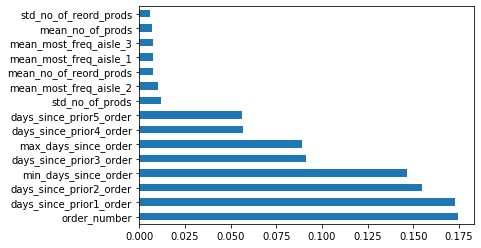

In [42]:
#Printing the important features
feat_importances = pd.Series(Xgb.feature_importances_, index=train_df[filtered_features_xgb].columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()


order_number seems to be the most important feature followed by the days_since_prior1_order. We should pass these through a linear model to see if it's coefficients are positive or negative or use a package called LIME to see its behaviour.

In [43]:
#Print metrics
Xgb_pred = Xgb.predict(test_df[filtered_features_xgb]).round(0)

test_df['predicted_days_till_next_order'] = Xgb_pred

print("Train metrics: ")
Xgb_pred_T = Xgb.predict(train_df[filtered_features_xgb]).round(0)
calc_metrics(train_df,Xgb_pred_T,len(filtered_features_xgb),constant=False)

print("----------------------------")

print("Test metrics: ")
calc_metrics(test_df,Xgb_pred,len(filtered_features_xgb),constant=False)

Train metrics: 
MAE: 6.51028
MSE: 66.3086
RMSE: 8.143009271761883
----------------------------
Test metrics: 
MAE: 7.1982
MSE: 81.4278
RMSE: 9.023735368460226


C:\Users\irfaa\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


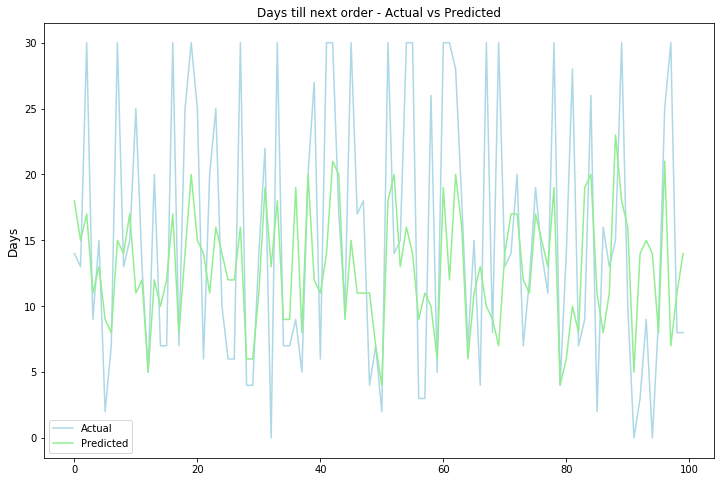

In [44]:
#Plot the actual vs prediction for first 100 records
x_ax = range(100)
plt.figure(figsize=(12,8))
plt.plot(x_ax, test_df['days_till_next_order'][0:100], label='Actual',color='lightblue')
plt.plot(x_ax, Xgb_pred[0:100], label='Predicted',color='lightgreen')
plt.title('Days till next order - Actual vs Predicted')
plt.ylabel('Days',fontsize=12)
plt.legend()
plt.show()

The plot shows the Actual and the prediction of "days_till_next_order", we can see that it is picking up the pattern, however, it fails at extreme days. Overall the MAE in days is about 7 for the entire data of 5000 records. 

In [45]:
test_df.head()

,user_id,order_id,order_number,order_dow,order_hour_of_day,mean_no_of_prods,mean_no_of_reord_prods,std_no_of_prods,std_no_of_reord_prods,mean_most_freq_aisle_1,mean_most_freq_aisle_2,mean_most_freq_aisle_3,mean_days_since_order,std_days_since_order,max_days_since_order,min_days_since_order,days_since_prior1_order,days_since_prior2_order,days_since_prior3_order,days_since_prior4_order,days_since_prior5_order,days_till_next_order,eval_set_new,predicted_days_till_next_order
5,1,2550362,10,4,8,5.900000,4.100000,1.523884,1.791957,73.0,53.0,41.0,19.555556,9.395625,30.0,0.0,30.0,0.0,14.0,20.0,19.0,14.0,test,18.0
12,29,1647841,18,5,11,12.500000,8.777778,4.176263,3.904079,69.0,46.0,65.0,11.529412,2.718401,17.0,7.0,14.0,11.0,12.0,16.0,17.0,13.0,test,15.0
19,98,1993729,14,5,8,3.571429,1.642857,3.298351,1.215739,40.0,45.0,53.0,20.307692,10.168453,30.0,5.0,8.0,30.0,30.0,15.0,30.0,30.0,test,17.0
26,174,1725709,27,4,17,6.407407,3.296296,2.649518,1.659815,26.0,33.0,29.0,11.269231,8.497330,30.0,2.0,11.0,7.0,16.0,12.0,7.0,9.0,test,11.0
33,182,2750011,26,5,21,7.846154,5.192308,2.072531,2.227451,79.0,47.0,26.0,12.400000,7.216878,30.0,4.0,7.0,26.0,15.0,5.0,15.0,15.0,test,13.0


In [46]:
test_df['absolute_error_days'] = abs(test_df['days_till_next_order']-test_df['predicted_days_till_next_order'])

C:\Users\irfaa\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
eval_result = pd.DataFrame(test_df['absolute_error_days'].value_counts(normalize=True).sort_index()).reset_index()
eval_result['absolute_error_days_cumsum'] = eval_result['absolute_error_days'].cumsum()

In [48]:
eval_result.head(7)

,index,absolute_error_days,absolute_error_days_cumsum
0,0.0,0.0528,0.0528
1,1.0,0.0962,0.1490
2,2.0,0.0942,0.2432
3,3.0,0.0792,0.3224
4,4.0,0.0806,0.4030
5,5.0,0.0662,0.4692
6,6.0,0.0628,0.5320


C:\Users\irfaa\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


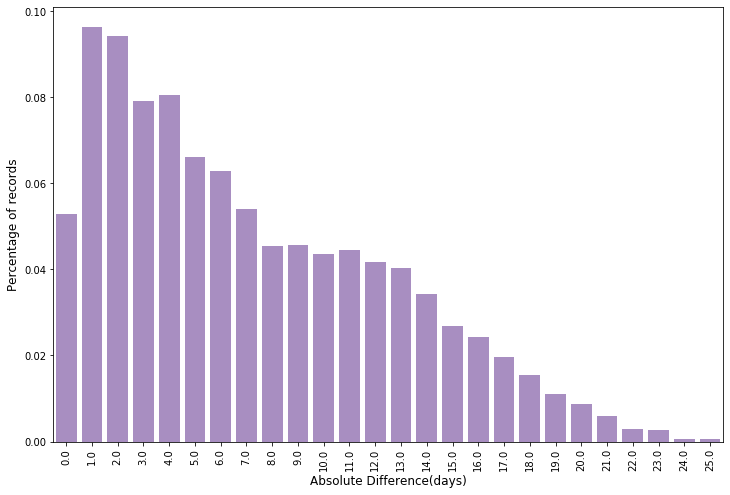

In [49]:
plt.figure(figsize=(12,8))
sns.barplot(eval_result['index'].values, eval_result['absolute_error_days'].values, alpha=0.8, color=color[4])
#plt.plot(eval_result.index, eval_result['absolute_error_days_cumsum'],color = 'orange',linewidth=2.0)
plt.ylabel('Percentage of records', fontsize=12)
plt.xlabel('Absolute Difference(days)', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

The plot shows the absolute error in predicting the "days till next order date". More than 30% of the users in the dataset of 5000 records were predicted with an absolute error of upto 3 days. This can defintely be improved with adding more features and acquiring more data about the users

## Next steps

**Some of the points on ETL and deployment on the entire dataset:**

* It would make sense to process the data on the cloud using Pyspark. It would still require some of the pandas functions for aggregations and this would require more resources.
* A fast algorithm like XGBoost might be one of the solutions for predicting. However, XGBoost in Pyspark has to be integrated externally as it is not present in the SparkML library. Another solution to this, would be a part of the customer segmentation. This would make sure we do not train the data on the entire dataset and only samples from different segments. 
* The model can be deployed on the cloud platforms like AWS which is a IAAS. The data for each user should be processed after their purchase. Ideally, every day for those users that have placed an order the same day. However, the model can be trained based on the resources and time it takes along with the features involved.


**The model built can be improved by considering some of the points below:**

* To get more features like quantity bought, week of the month and amount spent in the month which might help get more details of the user
* This model can be extended at a product level that would determine the "next order date" for a specific product. This would help personlize the offers